### Mask-RCNN inference with tensorflow, onnxruntime, TensorRT engine.  Balloon dataset

In [1]:
import os
os.chdir('..')

In [2]:
import subprocess
import cv2
import numpy as np
import tf2onnx
import onnx
import onnxruntime as ort
import onnx_graphsurgeon as gs
import matplotlib.pyplot as plt

from layers import losses
from training import get_optimizer
from model import mask_rcnn_functional
from common import inference_utils
from common.inference_utils import process_input
from common import utils
from common.config import CONFIG

from common.inference_optimize import maskrcnn_to_onnx, modify_onnx_model

import tensorflow as tf
utils.tf_limit_gpu_memory(tf, 1500)

1 Physical GPUs, 1 Logical GPUs Memory limit: 1500
Physical GPU-devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2021-06-24T02:58:03.658788+03:00

Python implementation: CPython
Python version       : 3.7.7
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-65-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

onnxruntime      : 1.6.0
numpy            : 1.18.5
tf2onnx          : 1.9.0
onnx_graphsurgeon: 0.2.6
cv2              : 4.1.0
onnx             : 1.8.1
tensorflow       : 2.2.0
matplotlib       : 3.2.2



#### Prepare model for inference

In [4]:
weights_path = os.path.join('..', 'tests', 'samples', 'balloon', 
                            'maskrcnn_mobilenet_ed3e7dd4c2e064d9dd92df2088834243_cp-0029.ckpt'
                           )
weights_path

'../tests/samples/balloon/maskrcnn_mobilenet_ed3e7dd4c2e064d9dd92df2088834243_cp-0029.ckpt'

In [5]:
# Loading inference graph and import weights

CONFIG.update({'class_dict': {'balloon': 1, 'background': 0},
               'num_classes': 2,
              },
             )
CONFIG.update({'meta_shape': (1 + 3 + 3 + 4 + 1 + CONFIG['num_classes']),})

inference_config = CONFIG
inference_config.update({'training': False})
inference_model = mask_rcnn_functional(config=inference_config)
inference_model = inference_utils.load_mrcnn_weights(model=inference_model,
                                                     weights_path=weights_path,
                                                     verbose=True
                                                    )

[MaskRCNN] Inference mode

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[MaskRCNN] Backbone architecture: mobilenet


/home/alexander/anaconda3/envs/tf_env/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



Weights for inference graph will be transferred from training graph

[MaskRCNN] Training mode

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[MaskRCNN] Backbone architecture: mobilenet
MaskRCNN Losses:
rpn_class_loss: <layers.losses.RPNClassLoss object at 0x7f8d986c9b10>
rpn_bbox_loss: <layers.losses.RPNBboxLoss object at 0x7f8d98648310>
mrcnn_class_loss: <layers.losses.MRCNNClassLoss object at 0x7f8db81edc90>
mrcnn_bbox_loss: <layers.losses.MRCNNBboxLoss object at 0x7f8db81b5410>
mrcnn_mask_loss: <layers.losses.MRCNNMaskLoss object at 0x7f8db8334a

rpn_model (Model)               ((None, None, 2), (N 1188864     fpn_p2[0][0]                     
                                                                 fpn_p3[0][0]                     
                                                                 fpn_p4[0][0]                     
                                                                 fpn_p5[0][0]                     
                                                                 fpn_p6[0][0]                     
__________________________________________________________________________________________________
concat_rpn_class (Concatenate)  (None, None, 2)      0           rpn_model[1][1]                  
                                                                 rpn_model[2][1]                  
                                                                 rpn_model[3][1]                  
                                                                 rpn_model[4][1]                  
          

---

#### Run several tests with tensorflow

In [6]:
test_images_path = '../tests/images/balloon'
os.listdir(test_images_path)

['14898532020_ba6199dd22_k.jpg']

14898532020_ba6199dd22_k.jpg 
Output shapes:
(1, 100, 6)
(1, 1000, 2)
(1, 1000, 2, 4)
(1, 100, 28, 28, 2)
(1, 1000, 4)
(1, 65472, 2)
(1, 65472, 4)


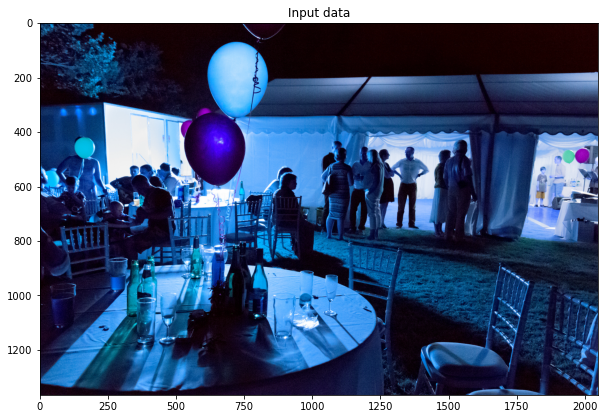

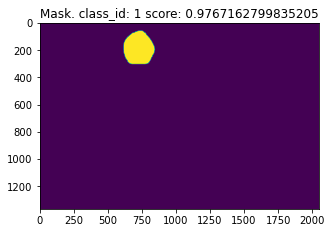

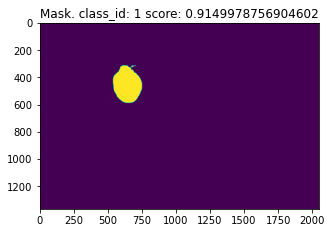

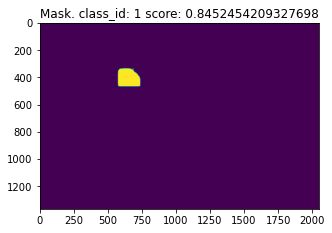

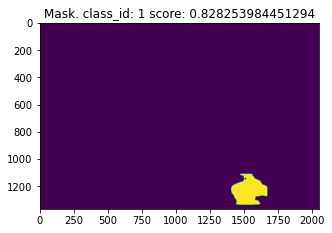

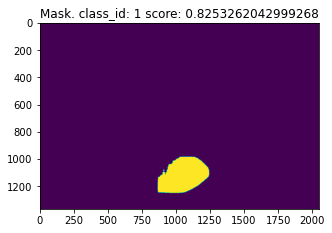

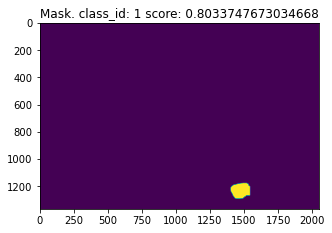

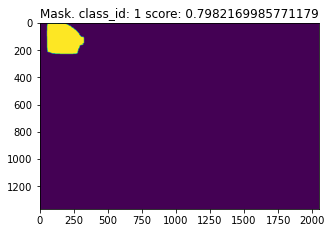

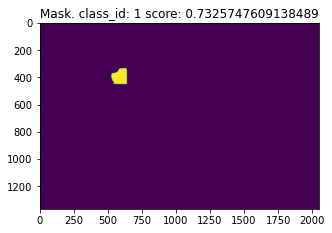

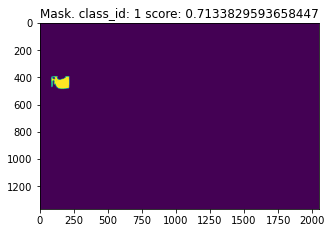

In [7]:
for img_name in os.listdir(test_images_path):
    img = cv2.imread(os.path.join(test_images_path, img_name))
    img_processed, image_meta, window = process_input(img, CONFIG)
    
    output = inference_model([np.expand_dims(img_processed, 0),
                              np.expand_dims(image_meta, 0)]
                            ) 
    
    detections, mrcnn_probs, mrcnn_bbox, mrcnn_mask, rpn_rois, rpn_class, rpn_bbox = output
    
    print(img_name, '\nOutput shapes:')
    for out in output:
        print(out.shape)
    
    
    # Extract bboxes, class_ids, scores and full-size masks
    boxes, class_ids, scores, full_masks = \
    utils.reformat_detections(detections=detections[0].numpy(), 
                              mrcnn_mask=mrcnn_mask[0].numpy(), 
                              original_image_shape=img.shape, 
                              image_shape=img_processed.shape, 
                              window=window
                             )
    
    fig=plt.figure(figsize=(10,10))
    plt.title('Input data')
    plt.imshow(img)
    
    for c, s, fm in zip(class_ids, scores, np.moveaxis(full_masks, -1, 0)):

        fig=plt.figure(figsize=(5,5))
        plt.title(f'Mask. class_id: {c} score: {s}')
        plt.imshow(fm)

#### Convert model to .onnx with tf2onnx

In [ ]:
input_spec = (
    tf.TensorSpec((CONFIG['batch_size'], *CONFIG['image_shape']), tf.float32, name="input_image"),
    tf.TensorSpec((CONFIG['batch_size'], CONFIG['meta_shape']), tf.float32, name="input_image_meta")
)
model_name = f"""maskrcnn_{CONFIG['backbone']}_{'_'.join(list(map(str, CONFIG['image_shape'])))}""" 

In [ ]:
maskrcnn_to_onnx(model=inference_model, 
                 model_name = model_name,
                 input_spec=input_spec,
                 kwargs={'opset': 11}
                )

#### Load onnx model and check it 

In [8]:
# Load the ONNX model
model = onnx.load(f"""../weights/maskrcnn_{CONFIG['backbone']}_512_512_3.onnx""")
# Check that the IR is well formed
onnx.checker.check_model(model)
# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

graph tf2onnx (
  %input_image[FLOAT, 1x512x512x3]
  %input_image_meta[FLOAT, 1x14]
) initializers (
  %slice_axes__590[INT32, 1]
  %slice_axes__1150[INT32, 2]
  %new_shape__1563[INT64, 4]
  %mask_rcnn_inference/rpn_model_4/rpn_conv_shared/Conv2D/ReadVariableOp:0[FLOAT, 512x256x3x3]
  %mask_rcnn_inference/rpn_model_3/rpn_bbox_pred/Conv2D/ReadVariableOp:0[FLOAT, 12x512x1x1]
  %mask_rcnn_inference/rpn_model/rpn_class_raw/Conv2D/ReadVariableOp:0[FLOAT, 6x512x1x1]
  %mask_rcnn_inference/roi_align_mask/range/delta:0[INT32, scalar]
  %mask_rcnn_inference/roi_align_classifier/truediv/x:0[FLOAT, scalar]
  %mask_rcnn_inference/roi_align_classifier/range/start:0[INT32, scalar]
  %mask_rcnn_inference/roi_align_classifier/mul_2/y:0[INT32, scalar]
  %mask_rcnn_inference/roi_align_classifier/add/x:0[INT32, scalar]
  %mask_rcnn_inference/roi_align_classifier/PadV2/constant_values:0[INT32, scalar]
  %mask_rcnn_inference/roi/sub_4/x:0[INT32, scalar]
  %mask_rcnn_inference/roi/strided_slice_6:0[FLOAT, 6

#### Run several tests with onnxruntime

In [9]:
sess = ort.InferenceSession(f"""../weights/maskrcnn_{CONFIG['backbone']}_512_512_3.onnx""")
print(f'Inputs: {[x.name for x in sess.get_inputs()]}\nOutputs:{[x.name for x in sess.get_outputs()]}')

Inputs: ['input_image', 'input_image_meta']
Outputs:['mrcnn_detection', 'fpnclf_mrcnn_class', 'fpnclf_mrcnn_bbox_reshape', 'mrcnn_mask', 'roi', 'concat_rpn_class', 'concat_rpn_bbox']


14898532020_ba6199dd22_k.jpg 
Output shapes:
(1, 100, 6)
(1, 1000, 2)
(1, 1000, 2, 4)
(1, 100, 28, 28, 2)
(1, 1000, 4)
(1, 65472, 2)
(1, 65472, 4)


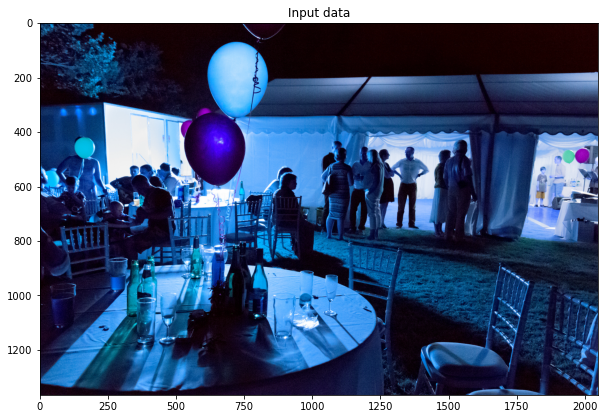

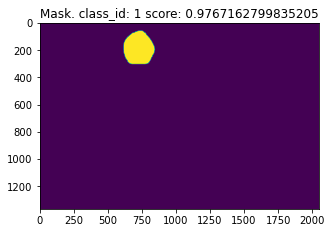

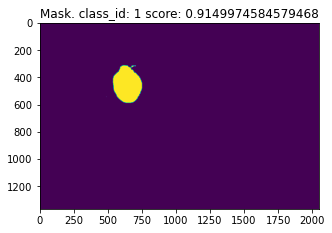

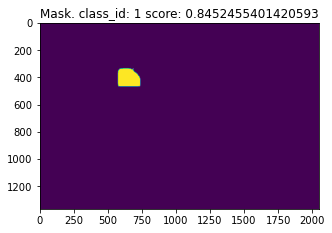

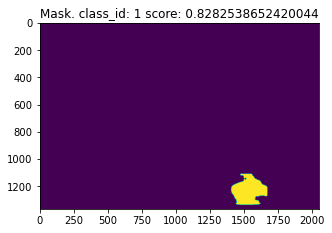

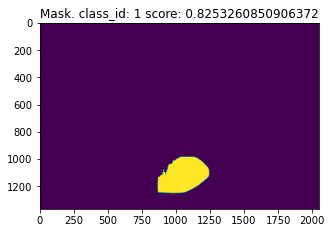

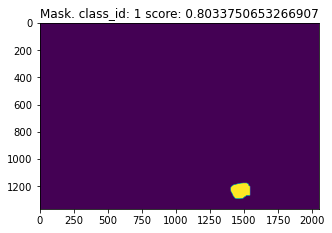

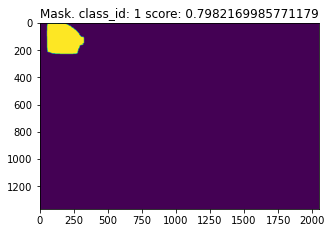

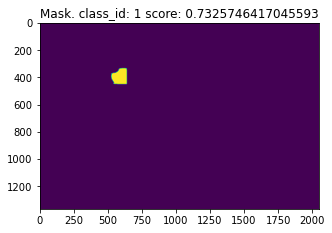

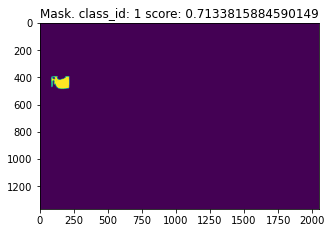

In [10]:
for img_name in os.listdir(test_images_path):
    img = cv2.imread(os.path.join(test_images_path, img_name))
    img_processed, image_meta, window = process_input(img, CONFIG)
    

    output = sess.run(output_names=[x.name for x in sess.get_outputs()], 
                      input_feed={'input_image': np.expand_dims(img_processed, 0).astype('float32'),
                                  'input_image_meta': np.expand_dims(image_meta, 0).astype('float32'),
                                 }
                     )
    
    detections, mrcnn_probs, mrcnn_bbox, mrcnn_mask, rpn_rois, rpn_class, rpn_bbox = output
    
    print(img_name, '\nOutput shapes:')
    for out in output:
        print(out.shape)
    
    
    # Extract bboxes, class_ids, scores and full-size masks
    boxes, class_ids, scores, full_masks = \
    utils.reformat_detections(detections=detections[0], 
                              mrcnn_mask=mrcnn_mask[0], 
                              original_image_shape=img.shape, 
                              image_shape=img_processed.shape, 
                              window=window
                             )
    
    fig=plt.figure(figsize=(10,10))
    plt.title('Input data')
    plt.imshow(img)

    for c, s, fm in zip(class_ids, scores, np.moveaxis(full_masks, -1, 0)):

        fig=plt.figure(figsize=(5,5))
        plt.title(f'Mask. class_id: {c} score: {s}')
        plt.imshow(fm)

#### Configure model for TensorRT

In [ ]:
modify_onnx_model(model_path=f'../weights/{model_name}.onnx',
                  config=CONFIG,
                  verbose=True
                 )

#### TensorRT optimization

__With trtexec:__ 

In [ ]:
%%time

os.chdir('../weights')

# Construct appropriate command
fp16_mode = False
command = [os.environ['TRTEXEC'],
           f'--onnx={model_name}_trt_mod.onnx',
           f'--saveEngine={model_name}_trt_mod_fp32.engine',
            '--workspace=2048',
            '--explicitBatch',
            '--verbose',
          ]

# fp16 param
if fp16_mode:
    command[2].replace('32', '16')
    command.append('--fp16')

# tacticSources param
# Do not neeed on jetson with aarch64 architecture for now.
arch = os.uname().machine
if arch == 'x86_64':
    command.append('--tacticSources=-cublasLt,+cublas')
    
print(f'\nArch: {arch}\ntrtexec command list: {command}')

result = subprocess.run(command, capture_output=True, check=True)
# Print stdout inference result
print(result.stdout.decode('utf8')[-2495:])

__With python TensorRT API:__


In [11]:
import tensorrt as trt
import pycuda.autoinit
import pycuda.driver as cuda

In [ ]:
max_batch_size = 1
# Precision mode
fp16_mode = False
# Workspace size in Mb
wspace_size = 2048

In [ ]:
%%time

# Init TensorRT Logger
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
# Init TensorRT plugins
trt.init_libnvinfer_plugins(TRT_LOGGER, "")
# Set tensorrt-prepared onnx model
onnx_model_path = f'../weights/{model_name}_trt_mod.onnx'
# Use explicit batch
explicit_batch = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

with trt.Builder(TRT_LOGGER) as builder, \
        builder.create_builder_config() as builder_config, \
        builder.create_network(explicit_batch) as network, \
        trt.OnnxParser(network, TRT_LOGGER) as parser:

    with open(onnx_model_path, 'rb') as model:
        parser.parse(model.read())

    print('Num of detected layers: ', network.num_layers)
    print('Detected inputs: ', network.num_inputs)
    print('Detected outputs: ', network.num_outputs)
    
    # Workspace size
    # 1e6 bytes == 1Mb
    builder_config.max_workspace_size = int(1e6 * wspace_size)
    
    # Precision mode
    if fp16_mode:
        builder_config.set_flag(trt.BuilderFlag.FP16)
    
    # Max batch size
    builder.max_batch_size = max_batch_size
    
    # Set the list of tactic sources
    # Do not need for Jetson with aarch64 architecture for now
    arch = os.uname().machine
    if arch == 'x86_64':
        tactic_source = 1 << int(trt.TacticSource.CUBLAS) | 0 << int(trt.TacticSource.CUBLAS_LT)
        builder_config.set_tactic_sources(tactic_source)
        
    
    # Make TensorRT engine
    engine = builder.build_engine(network, builder_config)
    
    # Save TensorRT engine
    if fp16_mode:
        trt_model_name = f'../weights/{model_name}_fp16_trt.engine'
    else:
        trt_model_name = f'../weights/{model_name}_fp32_trt.engine'

    with open(trt_model_name, "wb") as f:
        f.write(engine.serialize())

#### Run TensorRT inference

In [12]:
def trt_mrcnn_inference(model, image):
    """

    Args:
        model: tensorflow tf.keras.Model
        image: prepared image for inference

    Returns: boxes,
             class_ids, 
             scores, f
             ull_masks, 
             eval_gt_boxes, 
             eval_gt_class_ids, 
             eval_gt_masks

    """

    # Extract trt-variables from a dict for transparency
    engine = model['engine']
    stream = model['stream']
    context = model['context']
    device_input = model['device_input']
    device_output1 = model['device_output1']
    device_output2 = model['device_output2']

    host_output1 = model['host_output1']
    host_output2 = model['host_output2']

    # Make inference
    host_input = image.astype(dtype=np.float32, order='C')
    cuda.memcpy_htod_async(device_input, host_input, stream)
    context.execute_async(bindings=[int(device_input),
                                    int(device_output1),
                                    int(device_output2),
                                    ],
                          stream_handle=stream.handle)

    cuda.memcpy_dtoh_async(host_output1, device_output1, stream)
    cuda.memcpy_dtoh_async(host_output2, device_output2, stream)
    stream.synchronize()
    
    trt_mrcnn_detection = host_output1.reshape(
        engine.get_binding_shape('mrcnn_detection')).astype(dtype=np.float32)
    trt_mrcnn_mask = host_output2.reshape(
        engine.get_binding_shape('mrcnn_mask')).astype(dtype=np.float32)
    
    return trt_mrcnn_detection, trt_mrcnn_mask

In [13]:
def set_mrcnn_trt_engine(model_path):
    
    """
    Load TensorRT engine via pycuda
    Args:
        model_path: model path to TensorRT-engine

    Returns: python dict of attributes for pycuda model inference

    """
    
    trt_logger = trt.Logger(trt.Logger.VERBOSE)
    trt.init_libnvinfer_plugins(trt_logger, "")

    with open(model_path, "rb") as f, trt.Runtime(trt_logger) as runtime:
        engine = runtime.deserialize_cuda_engine(f.read())
    context = engine.create_execution_context()

    # Inputs
    input_shape = engine.get_binding_shape('input_image')
    input_size = trt.volume(input_shape) *\
                 engine.max_batch_size * np.dtype(np.float32).itemsize
    device_input = cuda.mem_alloc(input_size)

    # Outputs
    output_names = list(engine)[1:]

    # mrcnn_detection output
    output_shape1 = engine.get_binding_shape('mrcnn_detection')
    host_output1 = cuda.pagelocked_empty(trt.volume(output_shape1) *
                                              engine.max_batch_size,
                                              dtype=np.float32)
    device_output1 = cuda.mem_alloc(host_output1.nbytes)


    # mrcnn_mask output
    output_shape2 = engine.get_binding_shape('mrcnn_mask')
    host_output2 = cuda.pagelocked_empty(trt.volume(output_shape2) * engine.max_batch_size,
                                              dtype=np.float32)
    device_output2 = cuda.mem_alloc(host_output2.nbytes)

    # Setting a cuda stream
    stream = cuda.Stream()
    
    return {'engine': engine,
            'stream': stream,
            'context': context,
            'device_input': device_input,
            'device_output1': device_output1,
            'device_output2':device_output2,
            'host_output1': host_output1,
            'host_output2': host_output2
           }

In [14]:
trt_model = set_mrcnn_trt_engine(f"""../weights/maskrcnn_{CONFIG['backbone']}_512_512_3_trt_mod_fp32.engine""")

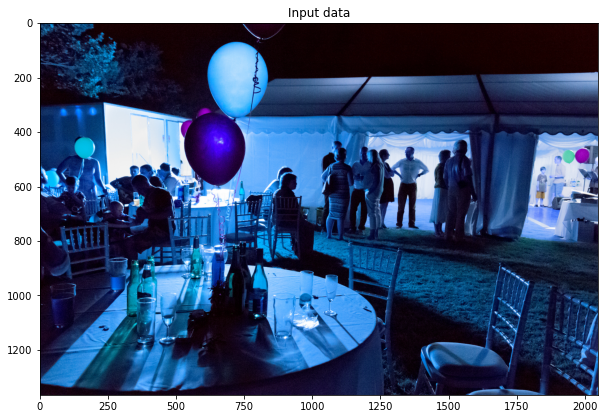

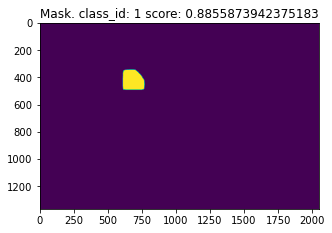

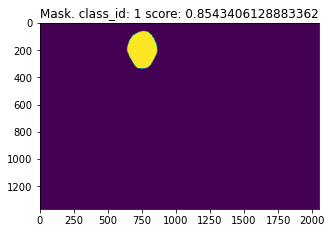

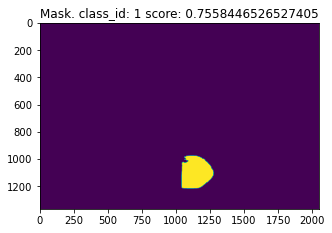

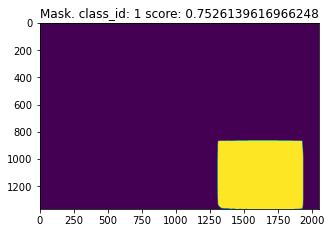

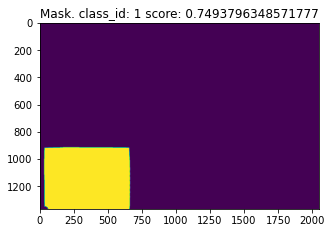

In [15]:
for img_name in os.listdir(test_images_path):
    img = cv2.imread(os.path.join(test_images_path, img_name))
    img_processed, image_meta, window = process_input(img, CONFIG)
    

    trt_mrcnn_detection, trt_mrcnn_mask = trt_mrcnn_inference(trt_model, np.expand_dims(img_processed, 0))
    

    # Extract bboxes, class_ids, scores and full-size masks
    boxes, class_ids, scores, full_masks = \
    utils.reformat_detections(detections=trt_mrcnn_detection[0], 
                              mrcnn_mask=trt_mrcnn_mask[0], 
                              original_image_shape=img.shape, 
                              image_shape=img_processed.shape, 
                              window=window
                             )
    
    fig=plt.figure(figsize=(10,10))
    plt.title('Input data')
    plt.imshow(img)

    for c, s, fm in zip(class_ids, scores, np.moveaxis(full_masks, -1, 0)):

        fig=plt.figure(figsize=(5,5))
        plt.title(f'Mask. class_id: {c} score: {s}')
        plt.imshow(fm)